# TCC - Pós graduação em Ciência de dados e Big data - UFPR
## Sistema de recomendação de animes

### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from surprise import Dataset, Reader, KNNWithMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score, recall_score

### Base de dados

In [2]:
df_anime_synopsis = pd.read_csv('anime_synopsis.csv')
df_anime = pd.read_csv('anime.csv')
df_anime_list = pd.read_csv('animelist.csv')
df_rating = pd.read_csv('rating_complete.csv')
df_status = pd.read_csv('watching_status.csv')

In [4]:
df_rating.columns

Index(['user_id', 'anime_id', 'rating'], dtype='object')

### Matriz

In [5]:
df_anime = df_anime.rename(columns={"MAL_ID": "anime_id"})
df_anime_name = df_anime[["anime_id", "Name"]]

df_anime_list_merge = df_anime_list.merge(df_anime_name.rename(columns={'Name': 'anime_name'}), on='anime_id', how='left')[["user_id", "anime_name", "anime_id", "rating", "watching_status", "watched_episodes"]]

In [6]:
count_user_id = df_anime_list_merge['user_id'].value_counts()
count_anime_id = df_anime_list_merge['anime_id'].value_counts()

df_anime_list_merge = df_anime_list_merge[
    df_anime_list_merge['user_id'].isin(
        count_user_id[count_user_id >= 500].index)].copy()

df_anime_list_merge = df_anime_list_merge[
    df_anime_list_merge['anime_id'].isin(
        count_anime_id[count_anime_id >= 200].index)].copy()

In [7]:
anime_rating_count = df_anime_list_merge.dropna(subset=['anime_name']).groupby('anime_name')['rating'].count().reset_index(name='rating_count')

In [8]:
df_anime_list_merge = df_anime_list_merge.merge(anime_rating_count, 
                                                left_on = 'anime_name', right_on = 'anime_name', how = 'left')

In [79]:
top_users = df_anime_list_merge['user_id'].value_counts().head(10000)
top_animes = df_anime_list_merge['anime_name'].value_counts().head(10000)

top_rating = df_anime_list_merge[df_anime_list_merge['user_id'].isin(top_users.index) & 
                            df_anime_list_merge['anime_name'].isin(top_animes.index)]

In [80]:
anime_matrix = top_rating.pivot_table(index='anime_name', columns='user_id', values='rating', aggfunc=np.sum)

anime_matrix = anime_matrix[top_users.index]
anime_matrix = anime_matrix.reindex(top_animes.index)
anime_matrix.fillna(0, inplace=True)

C:\Users\Pichau\AppData\Local\Temp\ipykernel_23524\3426114568.py:1: FutureWarning: The provided callable <function sum at 0x000001D762CE4F40> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


In [81]:
top_users = top_users.index
top_animes = top_animes.index

# Criando a matriz de ratings
user_anime_matrix = top_rating.pivot_table(index='user_id', columns='anime_name', values='rating', aggfunc=np.sum)

# Reordenando as colunas com base nos top_animes e filtrando para incluir apenas os top_users
user_anime_matrix = user_anime_matrix[top_animes]  # Reordena as colunas para os top_animes
user_anime_matrix = user_anime_matrix.reindex(top_users)  # Reordena as linhas para os top_users

# Preenchendo NaNs com 0
user_anime_matrix.fillna(0, inplace=True)

C:\Users\Pichau\AppData\Local\Temp\ipykernel_23524\2200168494.py:5: FutureWarning: The provided callable <function sum at 0x000001D762CE4F40> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


### Estudo

In [12]:
pd.set_option('display.max_columns', 500)

In [13]:
df_anime_estudo = df_anime.drop(['English name', 'Japanese name','Duration','Premiered','Producers','Licensors',
                                 'Studios','Score','Ranked','Members','Favorites','Watching',
                                 'Completed','On-Hold','Dropped','Plan to Watch','Score-10','Score-9','Score-8',
                                 'Score-7','Score-6','Score-5','Score-4','Score-3','Score-2','Score-1'], axis=1)
df_anime_estudo.replace('Unknown', np.nan, inplace=True)
df_anime_estudo = df_anime_estudo.dropna()
df_anime_estudo = df_anime_estudo.reset_index(drop=True)

#### Episodes

In [14]:
df_anime_estudo['Episodes'] = pd.to_numeric(df_anime_estudo['Episodes'], errors='coerce')
bin_edges = [0, 1, 12, 30, 50, 100, float('inf')]  # Intervalos: 0-1, 2-12, 13-30, 31-50, 51-100, 100+
bin_labels = ['1', '2-12', '12-30', '30-50', '50-100', '100+']
df_anime_estudo['Episodes_Range'] = pd.cut(df_anime_estudo['Episodes'], bins=bin_edges, labels=bin_labels, right=False)

In [15]:
df_anime_estudo = df_anime_estudo.drop(['Episodes'], axis=1)

#### Year

In [16]:
def extract_year(date_str):
    try:
        return pd.to_datetime(date_str).year
    except ValueError:
        return pd.NaT  

df_anime_estudo[['Aired_Start', 'Aired_End']] = df_anime_estudo['Aired'].str.split(' to ', expand=True)

df_anime_estudo['Aired_Start_Year'] = df_anime_estudo['Aired_Start'].apply(extract_year)

In [17]:
df_anime_estudo['Aired_Start_Year'].value_counts()

Aired_Start_Year
2017    864
2016    859
2018    825
2015    721
2014    695
       ... 
1937      2
2022      2
1945      1
1946      1
1944      1
Name: count, Length: 101, dtype: int64

In [18]:
df_anime_estudo = df_anime_estudo.dropna(subset=['Aired_Start_Year'])

bin_edges = [1940, 1970, 1985, 2000, 2010, 2015, 2030]  

bin_labels = ['1940-1970', '1970-1985', '1985-2000', '2000-2010', '2010-2015', '2015-2030']

df_anime_estudo['Aired_Start_Year_Range'] = pd.cut(df_anime_estudo['Aired_Start_Year'], bins=bin_edges, labels=bin_labels, right=False)


In [19]:
df_anime_estudo = df_anime_estudo.drop(['Aired','Aired_Start','Aired_End','Aired_Start_Year'], axis=1)

### Dummies

In [20]:
df_genres = df_anime_estudo['Genres'].str.get_dummies(sep=',')
df_Type = df_anime_estudo['Type'].str.get_dummies()
df_Source = df_anime_estudo['Source'].str.get_dummies()
df_Rating = df_anime_estudo['Rating'].str.get_dummies()
df_Episodes_Range = df_anime_estudo['Episodes_Range'].str.get_dummies()
df_Episodes_Aired_Start_Year_Range = df_anime_estudo['Aired_Start_Year_Range'].str.get_dummies()

In [21]:
df_anime_dummies = pd.concat([df_anime_estudo, 
                              df_genres,df_Type,
                              df_Source,
                              df_Rating,
                              df_Episodes_Range,
                              df_Episodes_Aired_Start_Year_Range], 
                              axis=1)


df_anime_dummies = df_anime_dummies.drop(['Genres', 'Type','Source','Rating','Episodes_Range','Aired_Start_Year_Range'], axis=1)

### Modelo k-means

In [22]:
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_anime_dummies.drop(columns=['Name', 'anime_id']))

df_normalized = pd.DataFrame(df_normalized, columns=df_anime_dummies.drop(columns=['Name', 'anime_id']).columns)

In [23]:
kmeans = KMeans(n_clusters=20, random_state=42)

df_anime_dummies['cluster'] = kmeans.fit_predict(df_normalized)

c:\Users\Pichau\Documents\Data_Science\Projetos\TCC\dados\.conda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
top_anime_per_cluster = df_anime_dummies.groupby('cluster').apply(lambda df: df.loc[df['Popularity'].idxmin()])

C:\Users\Pichau\AppData\Local\Temp\ipykernel_23524\3241104591.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_anime_per_cluster = df_anime_dummies.groupby('cluster').apply(lambda df: df.loc[df['Popularity'].idxmin()])


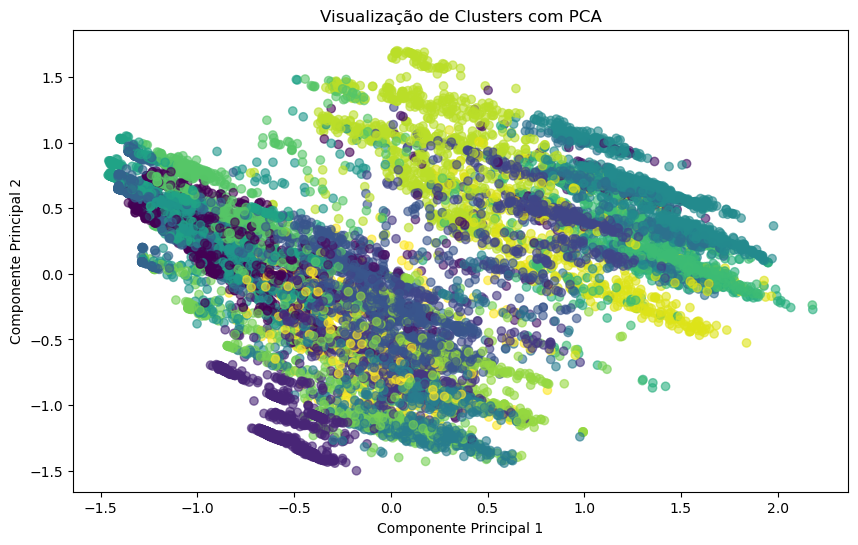

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Supondo que df_normalized e df_anime_dummies já estão definidos
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_normalized)  

plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df_anime_dummies['cluster'], cmap='viridis', alpha=0.6)
plt.title('Visualização de Clusters com PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.savefig('clusters_pca.png')  # Salvar como PNG
plt.show()


In [23]:
top_anime_per_cluster.index = top_anime_per_cluster.index + 1

In [24]:
englishname = pd.merge(top_anime_per_cluster, df_anime[['anime_id', 'English name']], on='anime_id', how='left')

englishname.index = englishname.index + 1
englishname[['English name','Name']]

,English name,Name
1,Spirited Away,Sen to Chihiro no Kamikakushi
2,Code Geass:Lelouch of the Rebellion,Code Geass: Hangyaku no Lelouch
3,Unknown,Boku no Pico
4,anohana:The Flower We Saw That Day,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...
5,Devilman:Crybaby,Devilman: Crybaby
6,Your Name.,Kimi no Na wa.
7,Shelter,Shelter
8,Death Note,Death Note
9,Hellsing Ultimate,Hellsing Ultimate
10,My Hero Academia,Boku no Hero Academia


### input

In [129]:
anime_names = []

clusters_input = input("Digite os números dos clusters (separados por vírgula): ")

clusters = [int(cluster.strip()) - 1 for cluster in clusters_input.split(',')]

for cluster in clusters:
    rows = top_anime_per_cluster[top_anime_per_cluster['cluster'] == cluster]
    if not rows.empty:
        anime_names.extend(rows['Name'])

print("Anime IDs correspondentes aos clusters digitados:")
print(anime_names)

Anime IDs correspondentes aos clusters digitados:
['Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.', 'Sword Art Online', 'Fullmetal Alchemist: Brotherhood']


In [138]:
anime_names = ['One Piece']

### modelo filtragem colaborativa

In [160]:
from sklearn.neighbors import NearestNeighbors
model_c = NearestNeighbors(metric="cosine", algorithm="brute")
model_c.fit(anime_matrix)

model_m = NearestNeighbors(metric="manhattan", algorithm="brute")
model_m.fit(anime_matrix)

model_e = NearestNeighbors(metric="euclidean", algorithm="brute")
model_e.fit(anime_matrix)

NearestNeighbors(algorithm='brute', metric='euclidean')

#### Preditores

In [167]:
def predict(anime_list):
    for anime in anime_list:
        if anime not in anime_matrix.index:
            print(f"Anime '{anime}' não encontrado na tabela.")
            continue

        anime_idx = anime_matrix.index.get_loc(anime)
        query = anime_matrix.iloc[anime_idx, :].values.reshape(1, -1)
        distance, suggestions = model.kneighbors(query, n_neighbors=6)
        
        print(f'Recommendations for {anime}:\n')
        for i in range(1, len(distance.flatten())):
            print('{0}: {1}, with distance of {2}:'.format(i, anime_matrix.index[suggestions.flatten()[i]], distance.flatten()[i]))
        print()


In [164]:
predict(anime_names)

Recommendations for Code Geass: Hangyaku no Lelouch:

1: Code Geass: Hangyaku no Lelouch R2, with distance of 7876.0:
2: Death Note, with distance of 24744.0:
3: Shingeki no Kyojin, with distance of 26438.0:
4: Fullmetal Alchemist: Brotherhood, with distance of 26631.0:
5: Steins;Gate, with distance of 26863.0:

Recommendations for Kimi no Na wa.:

1: Koe no Katachi, with distance of 20191.0:
2: Boku dake ga Inai Machi, with distance of 27718.0:
3: Re:Zero kara Hajimeru Isekai Seikatsu, with distance of 28438.0:
4: Shigatsu wa Kimi no Uso, with distance of 28822.0:
5: Shingeki no Kyojin Season 2, with distance of 29582.0:

Recommendations for Boku no Hero Academia:

1: Boku no Hero Academia 2nd Season, with distance of 10396.0:
2: Boku no Hero Academia 3rd Season, with distance of 17456.0:
3: One Punch Man, with distance of 20702.0:
4: Mob Psycho 100, with distance of 22614.0:
5: Nanatsu no Taizai, with distance of 22636.0:



In [161]:
def predictc(anime_list):
    recommendations = []

    for anime in anime_list:
        if anime not in anime_matrix.index:
            #print(f"Anime '{anime}' não encontrado na tabela de pivô.")
            return

    combined_vector = np.mean([anime_matrix.loc[anime].values for anime in anime_list], axis=0).reshape(1, -1)

    distance, suggestions = model_c.kneighbors(combined_vector, n_neighbors=10)  

    #print("Recommendations based on collective taste:\n")
    count = 0
    for i in range(1, len(distance.flatten())):
        recommended_anime = anime_matrix.index[suggestions.flatten()[i]]
        recommendation_distance = distance.flatten()[i]
        if recommended_anime not in anime_list:
            #print(f'{count + 1}: {recommended_anime}, with distance of {recommendation_distance}')
            recommendations.append((recommended_anime
                                    ))#, recommendation_distance))
            count += 1
            if count >= 10:  
                break

    return recommendations

#all_recommendations = predict2(anime_names)


In [162]:
def predictm(anime_list):
    recommendations = []

    for anime in anime_list:
        if anime not in anime_matrix.index:
            #print(f"Anime '{anime}' não encontrado na tabela de pivô.")
            return

    combined_vector = np.mean([anime_matrix.loc[anime].values for anime in anime_list], axis=0).reshape(1, -1)

    distance, suggestions = model_m.kneighbors(combined_vector, n_neighbors=10)  

    #print("Recommendations based on collective taste:\n")
    count = 0
    for i in range(1, len(distance.flatten())):
        recommended_anime = anime_matrix.index[suggestions.flatten()[i]]
        recommendation_distance = distance.flatten()[i]
        if recommended_anime not in anime_list:
            #print(f'{count + 1}: {recommended_anime}, with distance of {recommendation_distance}')
            recommendations.append((recommended_anime
                                    ))#, recommendation_distance))
            count += 1
            if count >= 10:  
                break

    return recommendations

In [163]:
def predicte(anime_list):
    recommendations = []

    for anime in anime_list:
        if anime not in anime_matrix.index:
            #print(f"Anime '{anime}' não encontrado na tabela de pivô.")
            return

    combined_vector = np.mean([anime_matrix.loc[anime].values for anime in anime_list], axis=0).reshape(1, -1)

    distance, suggestions = model_e.kneighbors(combined_vector, n_neighbors=10)  

    #print("Recommendations based on collective taste:\n")
    count = 0
    for i in range(1, len(distance.flatten())):
        recommended_anime = anime_matrix.index[suggestions.flatten()[i]]
        recommendation_distance = distance.flatten()[i]
        if recommended_anime not in anime_list:
            #print(f'{count + 1}: {recommended_anime}, with distance of {recommendation_distance}')
            recommendations.append((recommended_anime
                                    ))#, recommendation_distance))
            count += 1
            if count >= 10:  
                break

    return recommendations

In [142]:
all_recommendations = predictm(anime_names)
all_recommendations

['Angel Beats!',
 'Shingeki no Kyojin',
 'Toradora!',
 'Noragami',
 'Hataraku Maou-sama!',
 'No Game No Life',
 'Sword Art Online II']

### Explicação dos clusters

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

df_tree = df_anime_dummies.drop('Name', axis=1)

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df_tree.drop('cluster', axis=1), df_tree['cluster'], test_size=0.2, random_state=42)

# Criar e treinar um classificador de árvore de decisão
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)

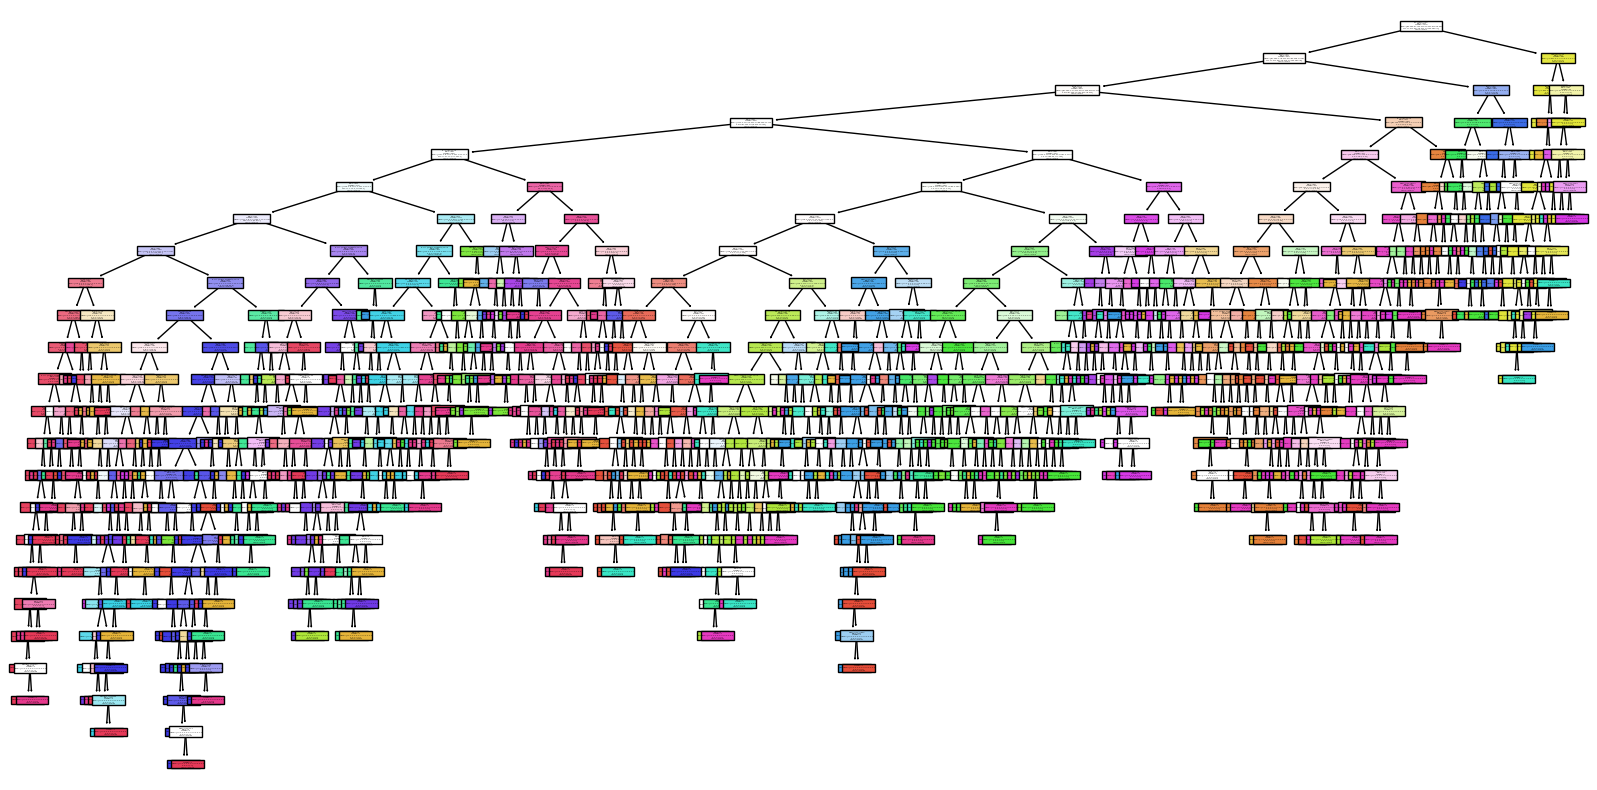

In [62]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plotar a árvore de decisão
plt.figure(figsize=(20,10))
plot_tree(tree_classifier, feature_names=df_tree.drop('cluster', axis=1).columns, class_names=[f'Cluster {i+1}' for i in range(20)], filled=True)
plt.show()



In [ ]:
from sklearn.tree import export_text

# Exportar a árvore de decisão como texto
tree_rules = export_text(tree_classifier, feature_names=list(df_tree.drop('cluster', axis=1).columns))
print(tree_rules)

|--- Rx - Hentai <= 0.50
|   |--- Music <= 0.50
|   |   |--- Movie <= 0.50
|   |   |   |--- 2-12 <= 0.50
|   |   |   |   |--- G - All Ages <= 0.50
|   |   |   |   |   |--- 2015-2030 <= 0.50
|   |   |   |   |   |   |--- 2010-2015 <= 0.50
|   |   |   |   |   |   |   |--- 12-30 <= 0.50
|   |   |   |   |   |   |   |   |---  Mecha <= 0.50
|   |   |   |   |   |   |   |   |   |--- Popularity <= 12554.50
|   |   |   |   |   |   |   |   |   |   |--- Comedy <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |   |--- Comedy >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |--- Popularity >  12554.50
|   |   |   |   |   |   |   |   |   |   |---  Comedy <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 17
|   |   |   |   |   |   |   |   |   |   |---  Comedy >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 18
|   |   |   |   |   |

### avaliação


In [84]:
anime_matrix_binary = anime_matrix > 8
user_anime_matrix_binary = user_anime_matrix >= 10

#### hit rate

In [ ]:
#Hit rate
hits = 0
total_tests = 0

# Percorre todos os usuários na matriz user_matrix
for user_id in user_anime_matrix_binary.index:
    # Obtém a lista de animes que o usuário curtiu
    liked_animes = user_anime_matrix_binary.columns[user_anime_matrix_binary.loc[user_id] == 1]
    #print("animes liked",liked_animes)
    
    # Verifica se o usuário tem animes curtidos
    if len(liked_animes) < 2:  # Se o usuário curtiu menos de 2 animes, não faz sentido testar
        continue

    # Testa um anime aleatoriamente para o usuário
    test_anime = np.random.choice(liked_animes, 1, replace=False)[0]  # Seleciona um anime para o teste
    liked_animes = liked_animes[liked_animes != test_anime]
    #print('animes teste', test_anime)
    #print('animes liked', liked_animes)
    recommendations = predictc(liked_animes)
    #print('recomedações', recommendations)
    if test_anime in recommendations:
        hits += 1
    total_tests += 1
    #print(hits)
    #print(total_tests)

# Calcula a taxa de acerto
hit_rate = hits / total_tests if total_tests > 0 else 0

print(f"Taxa de acerto: {hit_rate:.2f}")
print(hits)
print(total_tests)

In [ ]:
hits = 0
total_tests = 0

# Percorre todos os usuários na matriz user_matrix
for user_id in user_anime_matrix_binary.index:
    # Obtém a lista de animes que o usuário curtiu
    liked_animes = user_anime_matrix_binary.columns[user_anime_matrix_binary.loc[user_id] == 1]
    #print("animes liked",liked_animes)
    
    # Verifica se o usuário tem animes curtidos
    if len(liked_animes) < 2:  # Se o usuário curtiu menos de 2 animes, não faz sentido testar
        continue

    # Testa um anime aleatoriamente para o usuário
    test_anime = np.random.choice(liked_animes, 1, replace=False)[0]  # Seleciona um anime para o teste
    liked_animes = liked_animes[liked_animes != test_anime]
    #print('animes teste', test_anime)
    #print('animes liked', liked_animes)
    recommendations = predictm(liked_animes)
    #print('recomedações', recommendations)
    if test_anime in recommendations:
        hits += 1
    total_tests += 1
    #print(hits)
    #print(total_tests)

# Calcula a taxa de acerto
hit_rate = hits / total_tests if total_tests > 0 else 0

print(f"Taxa de acerto: {hit_rate:.2f}")
print(hits)
print(total_tests)

In [ ]:
hits = 0
total_tests = 0

# Percorre todos os usuários na matriz user_matrix
for user_id in user_anime_matrix_binary.index:
    # Obtém a lista de animes que o usuário curtiu
    liked_animes = user_anime_matrix_binary.columns[user_anime_matrix_binary.loc[user_id] == 1]
    #print("animes liked",liked_animes)
    
    # Verifica se o usuário tem animes curtidos
    if len(liked_animes) < 2:  # Se o usuário curtiu menos de 2 animes, não faz sentido testar
        continue

    # Testa um anime aleatoriamente para o usuário
    test_anime = np.random.choice(liked_animes, 1, replace=False)[0]  # Seleciona um anime para o teste
    liked_animes = liked_animes[liked_animes != test_anime]
    #print('animes teste', test_anime)
    #print('animes liked', liked_animes)
    recommendations = predicte(liked_animes)
    #print('recomedações', recommendations)
    if test_anime in recommendations:
        hits += 1
    total_tests += 1
    #print(hits)
    #print(total_tests)

# Calcula a taxa de acerto
hit_rate = hits / total_tests if total_tests > 0 else 0

print(f"Taxa de acerto: {hit_rate:.2f}")
print(hits)
print(total_tests)

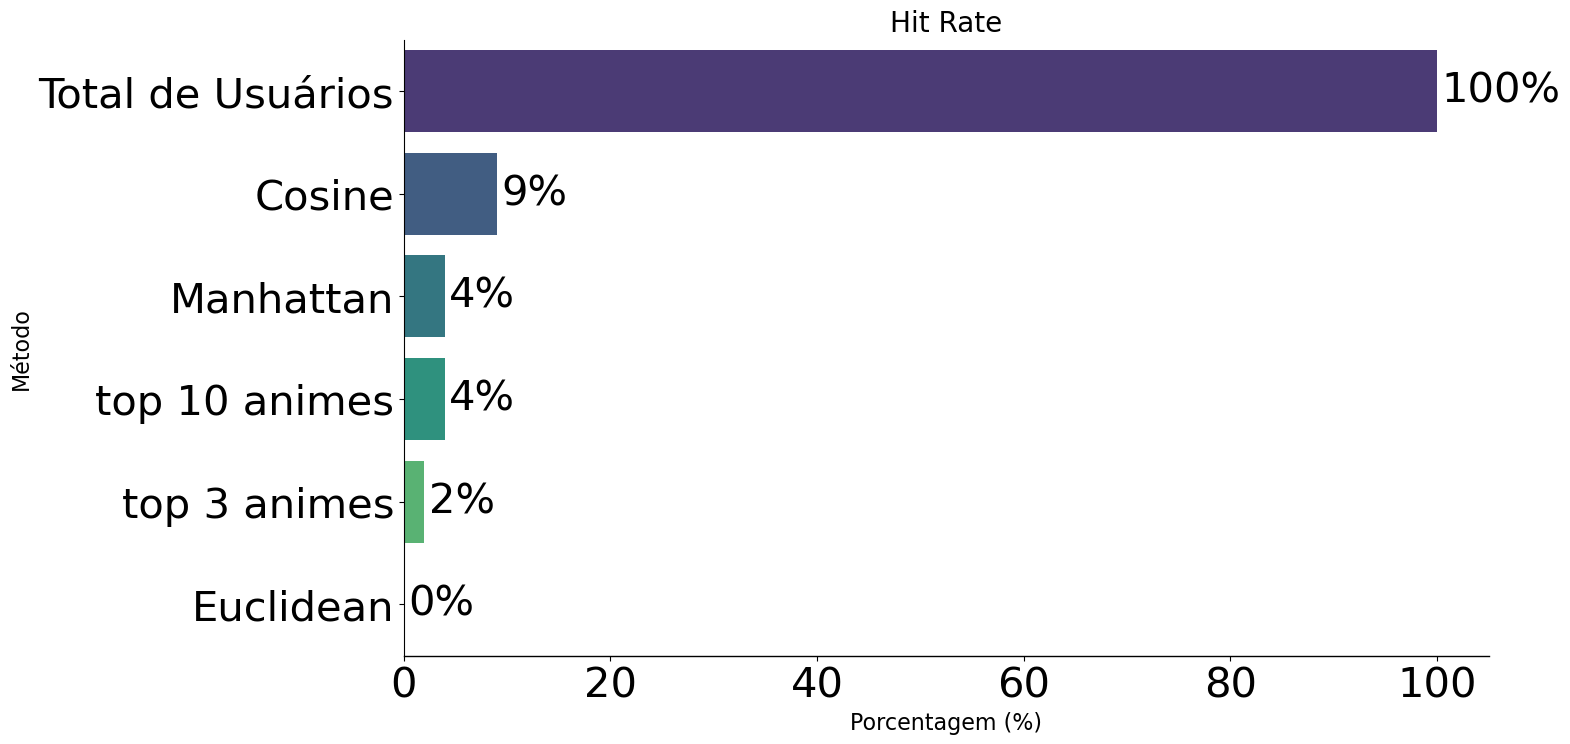

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Dados
data = {
    'Método': ['Total de Usuários', 'Cosine', 'Manhattan', 'top 10 animes', 'top 3 animes', 'Euclidean'],
    'Porcentagem': [100, 9, 4, 4, 2, 0]
}

# Criar DataFrame
df = pd.DataFrame(data)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x='Porcentagem', y='Método', data=df, palette='viridis')

# Adicionar anotações de porcentagem à direita das barras
for index, value in enumerate(df['Porcentagem']):
    bar_plot.annotate(f'{value}%', xy=(value, index), ha='left', va='center',
                      fontsize=30, color='black', xytext=(3, 0), textcoords='offset points')

# Adicionar títulos e labels com fontes maiores
plt.title('Hit Rate', fontsize=20)
plt.xlabel('Porcentagem (%)', fontsize=16)
plt.ylabel('Método', fontsize=16)

# Aumentar tamanho dos ticks
bar_plot.tick_params(labelsize=30)

# Remover as bordas (spines)
bar_plot.spines['top'].set_visible(False)
bar_plot.spines['right'].set_visible(False)


# Adicionar uma linha horizontal no eixo x
plt.gca().spines['bottom'].set_linewidth(1)  # Ajuste a largura da linha se desejar

# Exibir o gráfico
plt.show()


In [156]:
df_filtered = df_anime[df_anime['Popularity'] != 0]

# Ordenar o DataFrame pela coluna 'Popularity' (presume-se que valores menores indicam maior popularidade)
df_sorted = df_filtered.sort_values(by='Popularity')

# Selecionar os 10 animes mais populares
top_10_animes = df_sorted.head(10)

# Obter a lista com os nomes dos animes
top_10_names = top_10_animes['Name'].tolist()

# Exibir a lista dos nomes dos 10 animes mais populares
print(top_10_names)

['Death Note', 'Shingeki no Kyojin', 'Fullmetal Alchemist: Brotherhood', 'Sword Art Online', 'One Punch Man', 'Boku no Hero Academia', 'Tokyo Ghoul', 'Naruto', 'Steins;Gate', 'No Game No Life']


In [ ]:
#top 10
hits = 0
total_tests = 0

# Percorre todos os usuários na matriz user_matrix
for user_id in user_anime_matrix_binary.index:
    # Obtém a lista de animes que o usuário curtiu
    liked_animes = user_anime_matrix_binary.columns[user_anime_matrix_binary.loc[user_id] == 1]
    #print("animes liked",liked_animes)
    
    # Verifica se o usuário tem animes curtidos
    if len(liked_animes) < 2:  # Se o usuário curtiu menos de 2 animes, não faz sentido testar
        continue

    # Testa um anime aleatoriamente para o usuário
    test_anime = np.random.choice(liked_animes, 1, replace=False)[0]  # Seleciona um anime para o teste
    liked_animes = liked_animes[liked_animes != test_anime]
    #print('animes teste', test_anime)
    #print('animes liked', liked_animes)
    recommendations = top_10_names
    #print('recomedações', recommendations)
    if test_anime in recommendations:
        hits += 1
    total_tests += 1
    #print(hits)
    #print(total_tests)

# Calcula a taxa de acerto
hit_rate = hits / total_tests if total_tests > 0 else 0

print(f"Taxa de acerto: {hit_rate:.2f}")
print(hits)
print(total_tests)


#### Serendipity

In [157]:
import itertools
# Obter a lista com os nomes dos animes
top_10_names = top_10_animes['Name'].tolist()

# Lista de animes para testar
anime_list = [
    "Sen to Chihiro no Kamikakushi",
    "Code Geass: Hangyaku no Lelouch",
    "Boku no Pico",
    "Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.",
    "Devilman: Crybaby",
    "Kimi no Na wa.",
    "Shelter",
    "Death Note",
    "Hellsing Ultimate",
    "Boku no Hero Academia",
    "Cross Road",
    "Tengen Toppa Gurren Lagann: Parallel Works",
    "Toradora!",
    "Sword Art Online",
    "Kanojo to Kanojo no Neko: Everything Flows",
    "Golden Boy",
    "Mononoke Hime",
    "Little Witch Academia (TV)",
    "Fullmetal Alchemist: Brotherhood",
    "Byousoku 5 Centimeter"
]




In [ ]:

# Gerar todas as combinações possíveis de animes (n>=1)
combinations_list = []
for r in range(1, 3 + 1):
    combinations_list.extend(itertools.combinations(anime_list, r))

In [167]:
# cosine
count_in_top_10 = 0
total_predictions = 0

# Verificar quantas respostas do modelo estão no top 10 e contar o total de respostas
for combo in combinations_list:
    predictions = predictc(combo)
    for prediction in predictions:
        if prediction in top_10_names:
            count_in_top_10 += 1
        total_predictions += 1

print(f"Quantidade de respostas no top 10: {count_in_top_10}")
print(f"Quantidade total de respostas: {total_predictions}")

Quantidade de respostas no top 10: 5479
Quantidade total de respostas: 10721


In [168]:
# manhattan
count_in_top_10 = 0
total_predictions = 0

# Verificar quantas respostas do modelo estão no top 10 e contar o total de respostas
for combo in combinations_list:
    predictions = predictm(combo)
    for prediction in predictions:
        if prediction in top_10_names:
            count_in_top_10 += 1
        total_predictions += 1

print(f"Quantidade de respostas no top 10: {count_in_top_10}")
print(f"Quantidade total de respostas: {total_predictions}")

Quantidade de respostas no top 10: 1023
Quantidade total de respostas: 10252


In [169]:
# euclidean
count_in_top_10 = 0
total_predictions = 0

# Verificar quantas respostas do modelo estão no top 10 e contar o total de respostas
for combo in combinations_list:
    predictions = predicte(combo)
    for prediction in predictions:
        if prediction in top_10_names:
            count_in_top_10 += 1
        total_predictions += 1

print(f"Quantidade de respostas no top 10: {count_in_top_10}")
print(f"Quantidade total de respostas: {total_predictions}")

Quantidade de respostas no top 10: 1068
Quantidade total de respostas: 10172


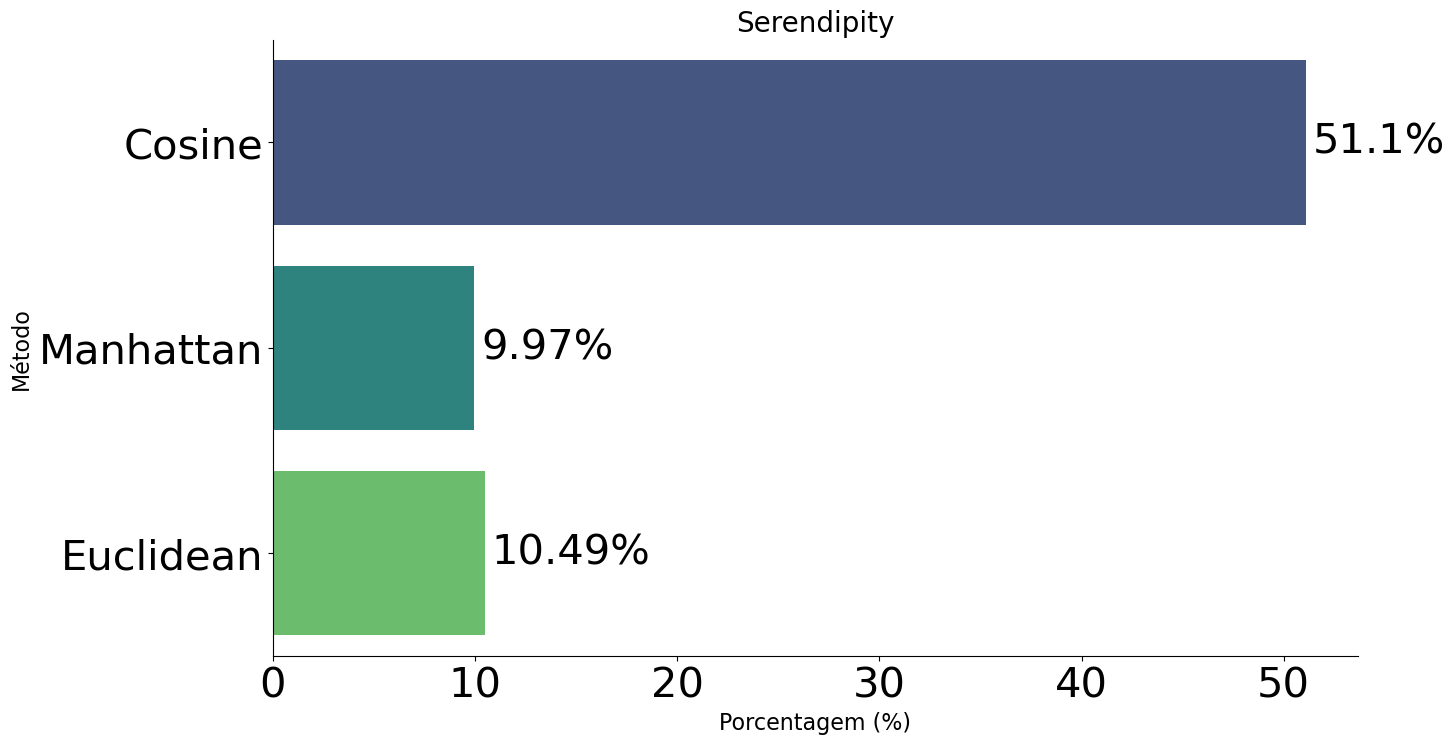

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Dados
data = {
    'Método': ['Cosine', 'Manhattan', 'Euclidean'],
    'Porcentagem': [51.10, 9.97, 10.49]
}

# Criar DataFrame
df = pd.DataFrame(data)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x='Porcentagem', y='Método', data=df, palette='viridis')

# Adicionar anotações de porcentagem à direita das barras com fonte maior
for index, value in enumerate(df['Porcentagem']):
    bar_plot.annotate(f'{value}%', xy=(value, index), ha='left', va='center',
                      fontsize=30, color='black', xytext=(5, 0), textcoords='offset points')

# Adicionar títulos e labels com fontes maiores
plt.title('Serendipity', fontsize=20)
plt.xlabel('Porcentagem (%)', fontsize=16)
plt.ylabel('Método', fontsize=16)

# Remover as bordas (spines)
bar_plot.spines['top'].set_visible(False)
bar_plot.spines['right'].set_visible(False)


# Aumentar tamanho dos ticks
bar_plot.tick_params(labelsize=30)

# Exibir o gráfico
plt.show()
